In [2]:
!pip install python-dotenv
from dotenv import load_dotenv
import os
load_dotenv()  # .env 파일에서 환경변수 로드

True

In [3]:
import openai
query = "2 + 2 x 3 = ?"

client = openai.OpenAI(
    api_key=os.getenv("OPENAI_API_KEY")
)
def cot_prompt(query):
  prompt = f"""다음 문제를 단계별로 풀어주세요, 각 단계를 번호로 구분하고 최종 답변을 명확하게 제시하세요
  {query}
  1. 문제 분석
  2. 계산
  3. 답변 확인
  """
  response = client.chat.completions.create(
      model="gpt-3.5-turbo",
      messages=[
          {"role": "system","content": "단계별로 문제를 해결하는 논리적인 시스템입니다" },
          {"role": "user","content": prompt }
      ],
      max_tokens=150,
      temperature = 0.7
  )
  return response.choices[0].message.content
result =  cot_prompt(query)
print(result)

# 검증
expected_answer = "8"
if expected_answer in result:
  print("검증 성공")
else:
  print("검증 실패")

1. 문제 분석:
주어진 수식은 '2 + 2 x 3'으로, 곱셈과 덧셈이 혼합되어 있습니다. 수식을 올바르게 이해하고 계산 순서를 정확히 파악해야 합니다.

2. 계산:
곱셈을 먼저 수행한 후 덧셈을 해야 합니다.
2 x 3 = 6
따라서, 2 + 6 = 8

3. 답변 확인:
따라서, 2 + 
검증 성공


Tree-of-Thoughts(ToT)
```
Cot를 트리구조로 확장, 각 단계에서 여러 가능성을 탐색
체스 수 예측, 각 선택의 결과를 트리분석기로 분석
탐색적 문제에 효과적, 단일경로(Cot)보다 유연
ToT는 다중 시나리오 분석(법률 시뮬레이션) , 다중경로 탐색
문제 : 3개의 상자중에 하나에 정답이있다, 첫번째 선택후 선택한 상자 공개, 선택을 바꾸면 정답이 있을 확률은 
```

Graph-of-Thoughts(GoT)
```
단계간 비선형 연결, 복잡한 관계를 그래프로 모델링
법률문서에서 조항 간 의존성(예 해지통지->보증금 반환)을 그래프로 표현
다중관점 reasoning, 법률/의료 복잡 도메인에 적합
법률조항해석, 조하간 관계 탐색
질문 예 : 임대차 계약에서 임차인의 계약 해지 통지 의무와 임대인의 보증금 반환 의무는 어떻게 연결되나요?

프롬프트 예 : 다음 문제를 Graph-of-Thoughts 방식으로 풀어주세요, 관련 개념(예 조항, 의무)를 노드로, 그 관계를 엣지로 구성해 
단계별로 분석하세요
{query}
1. 개념 노드 식별
2. 관계 엣지 분석
3. 최종 연결 설명명
```

Tool-augumented CoT
```
Cot에 외부도구(계산기,검색,API)를 통해 LLM의 계산/정보 한계 보완.
√(16) + 3^2 = ?  -> 계산기 도구를 이용해서 정확하게 계산
Toolformer 등
```

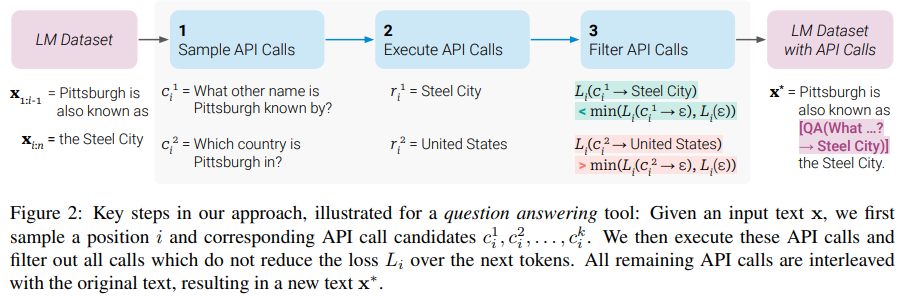

In [4]:
import re
client = openai.OpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
)
def tool_agumented_coat(query):
    def calculator(expression):
        # 간단한 계산기 기능 구현
        try:
            return eval(expression, {'__builtins__': {}}, {'sqrt': lambda x: x**0.5})
        except Exception as e:
            return None
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system","content": "calculator tool을 이용해서 문제를 해결하는 시스템" },
            {"role": "user","content": f"""
            다음 문제를 단계별로 풀어주세요, 계산이 필요하면 '[CALC: 식]' 으로 표기하고, 계산기 도구를 사용하세요, 150자이내로 답변하세요
            {query}
            1. 문제 분석
            2. 계산 단계
            3. 답변 확인
            """}
                
        ],
        max_tokens=150,
        # temperature = 0.7
    )
    result = response.choices[0].message.content
    # 계산기 도구 사용
    calc_pattern = r'\[CALC: (.*?)\]'       # [CALC: sqrt(16)] and then [CALC: 3**2]
    for calc in re.findall(calc_pattern, result):
        calc_result = calculator(calc)
        if calc_result is not None:
            result += f"\n계산 결과: {calc} = {calc_result}"
    return result

In [5]:
query  = "√(16) + 3**2 = ?"
print(tool_agumented_coat(query))

1. 문제 분석: 제곱근 √(16)을 먼저 계산하고, 그 결과에 3의 제곱을 더합니다.
2. 계산 단계:
   - √(16) = 4 (계산기 도구 사용)
   - 3**2 = 9 (계산기 도구 사용)
   - 4 + 9 = 13
   따라서, √(16) + 3**2 = 13
3. 답변 확인: √(16) + 3**2 = 13


Self-Refinement, Cot + Toolformer ,ReAct2.0
```
Self-Refinementsm는 답변후 스스로 검토/수정, Toolformer는 자동화 도구 호출, ReAct2.0 Reasioning+acting 결합
```

In [ ]:
import os
client = openai.OpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
)
def self_refinement_cot(query):
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system","content": "자기 개선을 통해 문제를 해결하는 시스템" },
            {"role": "user","content": f"""
            다음 문제를 단계별로 풀어주세요, 답변 후 스스로 검토해 오류를 수정하세요, 400자이내로 답변하세요
            {query}
            1. 문제 분석
            2. 계산 단계
            3. 초기 답변
            4. 검토
            5. 최종 답변
            """}
                
        ],
        max_tokens=400,
        # temperature = 0.7
    )
    return response.choices[0].message.content

In [57]:
# 실행
query = "한 농부가 닭과 소를 합쳐 20마리 키운다, 다리 수는 50개이다 닭과 소는 각각 몇 마리인가?"   #닭 15 소 5
print(self_refinement_cot(query))

1. 문제 분석: 문제에서는 닭과 소의 총 마리 수와 다리 수가 주어졌다. 닭과 소의 수를 구하는 것이 목표이다.
2. 계산 단계: 닭을 D, 소를 C라고 하면 D + C = 20이고, 2D + 4C = 50 두 방정식을 풀어야 한다.
3. 초기 답변: 닭은 10마리, 소는 10마리이다.
4. 검토: 방정식을 풀면 닭은 15마리, 소는 5마리이다. 초기 답변이 틀렸다.
5. 최종 답변: 닭은 15마리, 소는 5마리이다. 답을 수정했다.


Cot Prompt Template 고도화
```
단계 수, 지시어, 츨력형식을 명확히 지정(예 수학은 "변수정의->계산->검증")
```

In [ ]:
import os
print(os.getenv('OPENAI_API_KEY'))  # 환경변수에서 API 키 가져오기

In [ ]:
# "사과 3개와 오렌지 2개는 13,000원 사과 2개와 오렌지 3개는 12,000원, 사과와 오렌지는 각각 얼마인가?"
# 기능을 불러와서 실행
import openai
import os
from  utils import advanced_cot_template
query = "사과 3개와 오렌지 2개는 13,000원 사과 2개와 오렌지 3개는 12,000원, 사과와 오렌지는 각각 얼마인가?"
client = openai.OpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
)
from utils import advanced_cot_template

print(advanced_cot_template(client,query))

1. 변수 정의: 
    - 사과의 가격을 x원, 오렌지의 가격을 y원이라고 정의합니다.

2. 방정식 설정:
    - 3x + 2y = 13000 (사과 3개와 오렌지 2개의 가격 합은 13,000원)
    - 2x + 3y = 12000 (사과 2개와 오렌지 3개의 가격 합은 12,000원)

3. 계산 과정:
    - 위 두 방정식을 풀어서 x와 y의 값을 구합니다.
    - 3x + 2y = 13000을 2배 해서 6x + 4y = 26000과 2x + 3y = 12000을 더해주면 5x + 7y = 38000이 됩니다.
    - 이를 풀면 x = 4000원, y = 3000원이 나옵니다.

4. 검토:
    - 위 방정식에 x = 4000원, y = 3000원을 대입하여 원래 방정식을 만족하는지 확인합니다.

5. 최종답변: "사과: 4000원, 오렌지: 3000원"


In [ ]:
# 실행환경 확인
import sys
print(sys.executable)

c:\Users\USER\miniconda3\envs\LLM\python.exe


xor 연산자를 이용한 암호화 셈플

In [8]:
original = "이건 미밀인데 너만 알고 있어"
key = 64

encoded = [ord(ch)^key for ch in original]
print(f"Encoded: {encoded}")
# Decoding
decoded = ''.join(chr(encoded[i] ^ key) for i in range(len(encoded)))   
print(f"Decoded: {decoded}")

Encoded: [50996, 44084, 96, 48056, 48192, 51000, 45872, 96, 45384, 47500, 96, 50444, 44192, 96, 51144, 50676]
Decoded: 이건 미밀인데 너만 알고 있어


In [34]:
!pip install cryptography
from cryptography.fernet import Fernet
# 키 생성 한번만
public_key = Fernet.generate_key()
print(f"Public Key: {public_key.decode()}")
# 암호화
original = "이건 미밀인데 너만 알고 있어"
fernet = Fernet(public_key)  # 객체생성
encrypted = fernet.encrypt(original.encode())
print(f"Encrypted: {encrypted.decode()}")
#복호화
decrypted = fernet.decrypt(encrypted).decode()
print(f"Decrypted: {decrypted}")

Public Key: CL1v8VE8hUFYLKqc5Wcu2TUDQfW3yxa0SGEpDip1rZ8=
Encrypted: gAAAAABoJtwL5GhzU8E0TVxUuGAPaGbR72d-zYJpx94ioFaOwoRMAs7vmbufPR_BFN6bJ6innsacHHElHkdLPavZNJvEhdK4aXzwA39gEz0gGKHpeCtfMIYkGwO0vWW6fRvvlbhzNpUr
Decrypted: 이건 미밀인데 너만 알고 있어


In [10]:
# few shot prompt 실행
from utils import few_shot_cot
# query = '닭과 소를 합쳐 20마리, 다리 수 50개일때 ,닭과 소는 각각 몇마리 인가?'
query = '''다음 리스트는 어떤 단어를 숫자로 표현한 암호화 문장인데..가능한 모든 방법을 사용해서 원래 문장으로 만들어줘
리스트 : Encoded: [50996, 44084, 96, 48056, 48192, 51000, 45872, 96, 45384, 47500, 96, 50444, 44192, 96, 51144, 50676]
'''
client = openai.OpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
)
result = few_shot_cot(client,query)
print(result)

1. 변수 정의:
- 암호화된 숫자를 나타내는 리스트를 Encoded로 정의하고, 각 숫자를 원래 단어로 변환한 결과를 Decoded로 정의합니다.

2. 방정식 설정:
- 주어진 Encoded 리스트를 Decoded로 변환하는 방법은 여러 가지이므로, 가능한 모든 방법을 고려해야 합니다.

3. 계산 과정:
- 가능한 모든 숫자와 단어의 매핑을 고려하여 각 숫자를 해당하는 단어로 변환합니다.
- 예를 들어, 50996이 'apple'이 될 수도 있고 다른 단어가 될 수도 있습니다.
- 따라서 Encoded 리스트의 각 숫자를 모든 가능한 단어로 대체하여 원래 문장을 찾습니다.

4. 검토:
- 각 숫자를 해당하는 단어로 대체한 후 원래 문장이 의미 있는 문장인지 확인합니다.

5. 최종 답변:
- 가능한 모든 방법을 고려하여 Encoded 리스트를 Decoded로 변환하여 원래 문장을 찾습니다.
